### Task Selection (AstroVizBench)

In [1]:
import json

with open('/Users/kahaan/Downloads/cmbagent/astrovisbench_queries.json', 'r') as f:
    queries = json.loads(f.read())  # List of dictionaries

for q in queries:
    if q['uid'] == 'dbaf0eac-4de5-4c4c-8721-13c9c4432cb8':  # Joint query task between photometric and spectroscopic catalogs
        query = q
        break

query.keys()

dict_keys(['nb_path', 'setup_query', 'setup_gt_code', 'processing_query', 'processing_gt_code', 'visualization_query', 'visualization_gt_code', 'visualization_gen_code', 'processing_gen_code', 'uid', 'gt_visualization', 'processing_underspecifications', 'visualization_underspecifications', 'nb_link'])

### Task Completion (cmbagent)

In [2]:
import os
import cmbagent
from PIL import Image
from google.genai import types
from google import genai

OAI_API_KEY = os.getenv('OPENAI_API_KEY')
GEMINI_API_KEY = os.getenv('GEMINI_API_KEY')

task = f"""
System:
You are tasked with completing a Jupyter Notebook about astronomy. You will be given some Markdown cells
and some Python code cells for context, and in response you must output only Python code that accurately
fulfills the goals of the notebook as described by the Markdown text.

Input:
Setup query: {query['setup_query']}
Ground truth setup code: {query['setup_gt_code']}
Processing query: {query['processing_query']}
Ground truth processing code: {query['processing_gt_code']}
Visualization query: {query['visualization_query']}
Visualization specifications: {query['visualization_underspecifications']}

Output:
Code generated for the visualzation query.
"""
results = cmbagent.one_shot(task,
                   max_rounds=50,
                   agent='engineer',
                   # agent='researcher',
                   engineer_model='gemini-2.5-flash',
                   work_dir="/Users/kahaan/Downloads/cmbagent/output",
                  )


System:
You are tasked with completing a Jupyter Notebook about astronomy. You will be given some Markdown cells
and some Python code cells for context, and in response you must output only Python code that accurately
fulfills the goals of the notebook as described by the Markdown text.

Input:
Setup query: # Setup

Ensure you have all the necessary libraries and modules imported for astronomical data analysis and visualization. This includes libraries for plotting, data handling, and any necessary scientific computation utilities. Additionally, set up Notebook-specific configurations, such as initializing plotting modes for inline display, and establish any required authentication for accessing external astronomical data repositories. This setup will provide a solid foundation for query execution and visualization tasks related to astronomical datasets.

Ground truth setup code: # std lib
from getpass import getpass

# 3rd party
import numpy as np
import matplotlib
import matplotlib.

### Simple VLM-as-a-judge

Rationale:
The visualization aims to show the RA and Dec positions of sources from two catalogs, LS and SDSS, with specific visual encodings for differentiation and verification of alignment.

1.  **Coordinate Data Adjustment and Range:** The plot displays RA on the x-axis ranging from 131 to 126 degrees and Dec on the y-axis ranging from 7 to 12 degrees. This demonstrates that the data has been adjusted to an appropriate range.
2.  **Axis Labels and Orientation:** The x-axis is correctly labeled "RA (degrees)" and the y-axis is labeled "Dec (degrees)". Crucially, the RA axis is reversed (decreasing from left to right), fulfilling the specific request for "reversed RA on the x-axis for the correct astronomical orientation."
3.  **Overplotting:** Both red and black markers are clearly overplotted on the same graph, allowing for direct visual comparison of source positions.
4.  **Visual Verification of Overlap and Alignment:** The high density of combined red and black 'X'-like markers, 

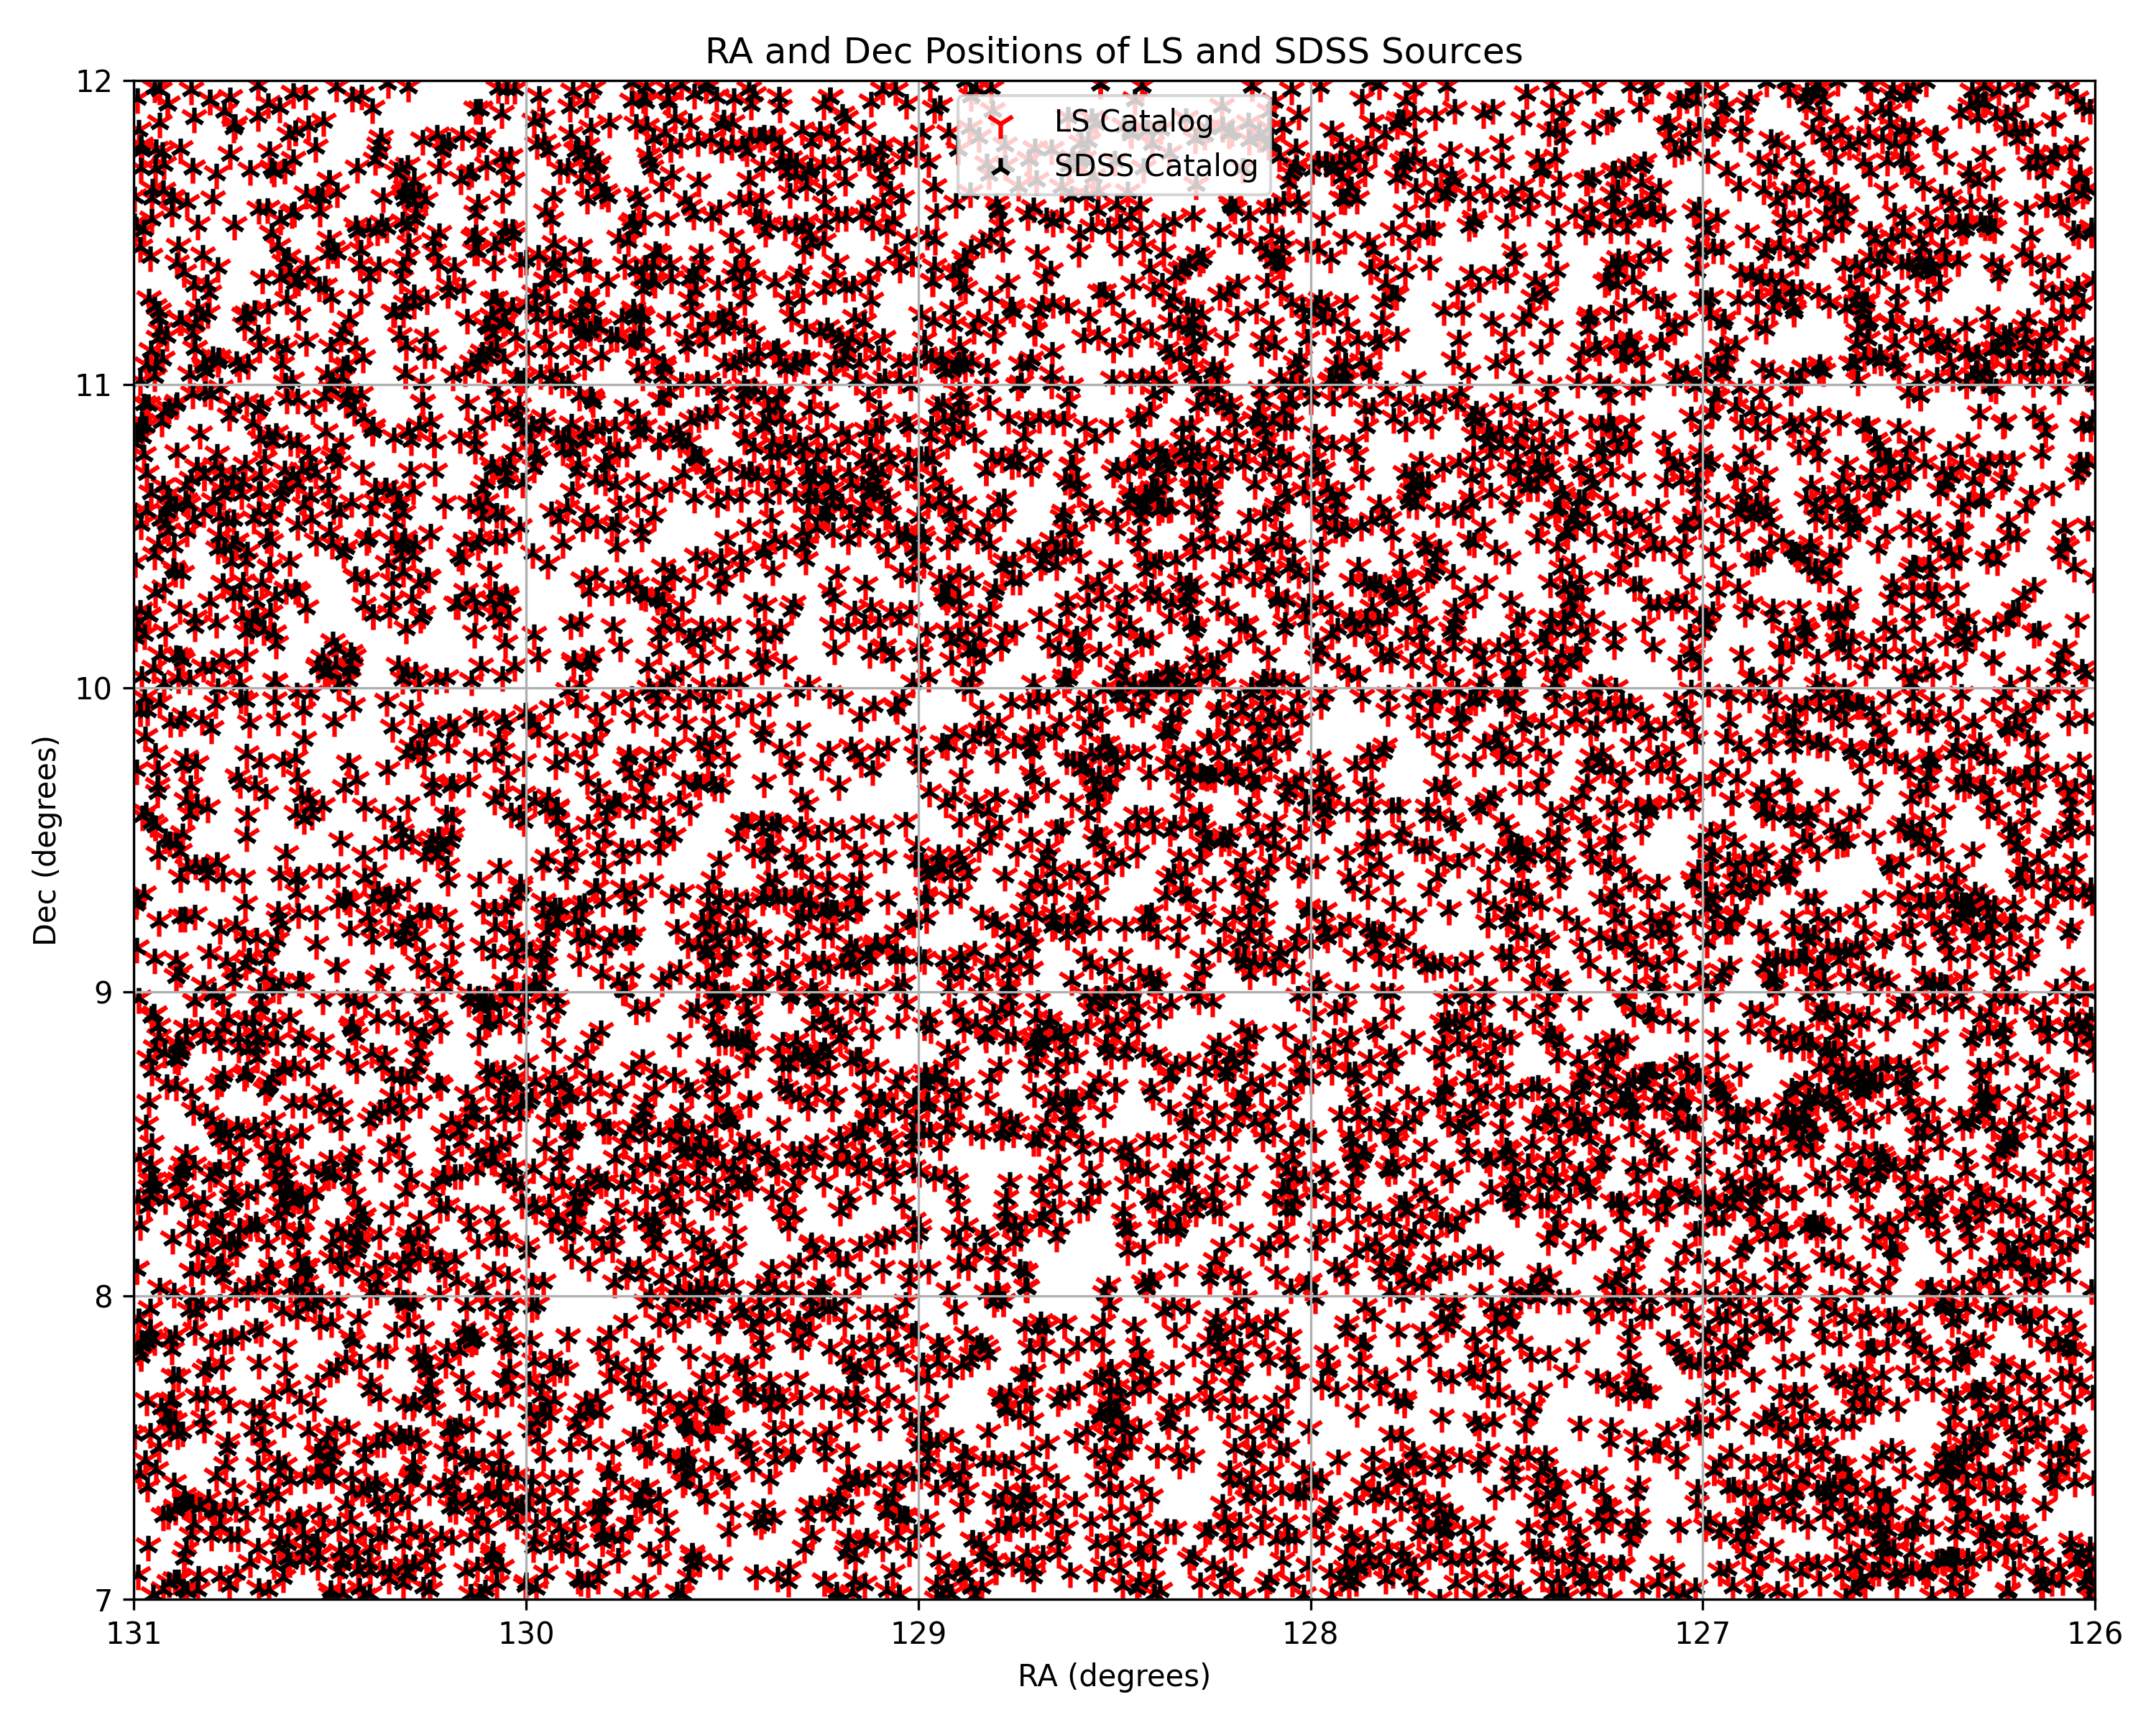

In [3]:
final_img_path = results['final_context'].data['displayed_images'][-1]

with open(final_img_path, 'rb') as f:
    image_bytes = f.read()
    client = genai.Client(api_key=GEMINI_API_KEY)
    
    response = client.models.generate_content(
        model='gemini-2.5-flash',
        contents=[
            types.Part.from_bytes(
                data=image_bytes,
                mime_type='image/png',
            ),
        f"""
        You are an expert astronomer. Your task is to evaluate the correctness and visual validity of 
        the visualization that will be sent to you. You will first return your rationale, and then a
        verdict of "No Error", "Minor Error", or "Major Error".
        
        You will be given the visualization query that the visualization was created to fulfill.
        Visualization query: {query['visualization_query']}.
        """
        ]
    )

print(response.text)
Image.open(final_img_path)

### Ground Truth Workflow: Setup, Processing, and Visualization


SELECT L.ra, L.dec, L.type, L.sersic, L.g_r, L.r_z,
S.z, S.ra as plug_ra, S.dec as plug_dec, S.class, S.veldisp, S.veldisperr
FROM ls_dr10.tractor AS L
JOIN ls_dr10.x1p5__tractor__sdss_dr17__specobj AS X ON L.ls_id=X.id1
JOIN sdss_dr17.specobj AS S ON X.id2 = S.specobjid
WHERE L.ra BETWEEN 126 AND 131 AND L.dec BETWEEN 7.0 AND 12.0 AND (L.ra_ivar > 0)
LIMIT 100000



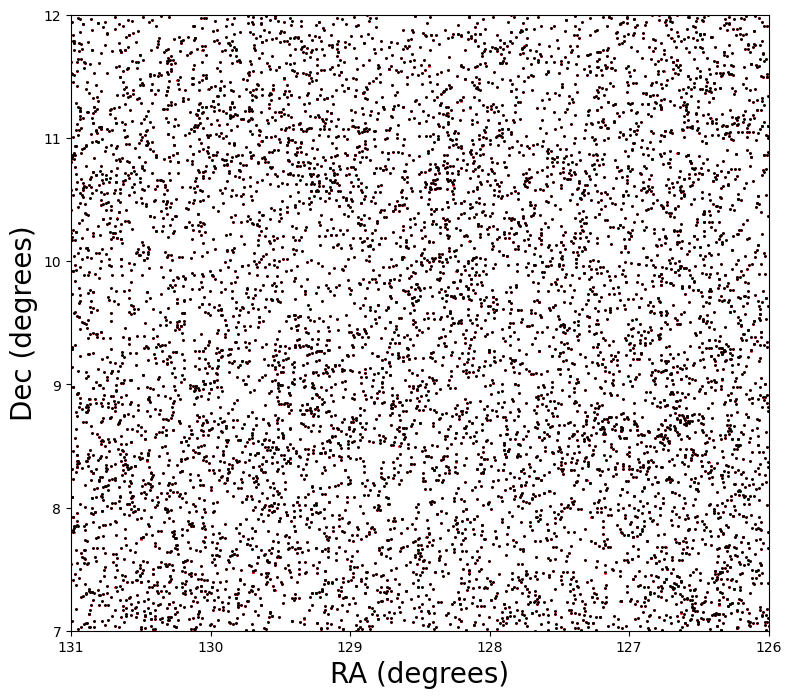

In [7]:
# == SETUP == #

from getpass import getpass

# 3rd party
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.stats import binned_statistic_2d
%matplotlib inline
from astropy.table import Table
from astropy.cosmology import Planck18 as cosmo
import plotly
import plotly.graph_objs as go
import pandas as pd
plotly.offline.init_notebook_mode()

# Data Lab
from dl import queryClient as qc
from dl import authClient as ac

# == PROCESSING == #

# Write query statement (sql)
query = ("""
SELECT L.ra, L.dec, L.type, L.sersic, L.g_r, L.r_z,
S.z, S.ra as plug_ra, S.dec as plug_dec, S.class, S.veldisp, S.veldisperr
FROM ls_dr10.tractor AS L
JOIN ls_dr10.x1p5__tractor__sdss_dr17__specobj AS X ON L.ls_id=X.id1
JOIN sdss_dr17.specobj AS S ON X.id2 = S.specobjid
WHERE L.ra BETWEEN %s AND %s AND L.dec BETWEEN %s AND %s AND (L.ra_ivar > 0)
LIMIT 100000
""") % (126,131,7.,12.) # small region

print(query)

# Call query client and save output as Astropy Table
result = qc.query(adql=query, fmt='table')

# == VISUALIZATION == #

# convert RA coordinates from [0,360] to [-180,180]
chgsign = np.where(result['ra'] > 180)
result['ra'][chgsign] = result['ra'][chgsign]-360.
result['plug_ra'][chgsign] = result['plug_ra'][chgsign]-360.

plt.figure(figsize=(9,8))

# plot RA, Dec from LS catalog in red with larger symbols
plt.scatter(result['ra'],result['dec'],s=3,color='red',marker='1')

# overplot RA, Dec from SDSS catalog in blue with smaller symbols
plt.scatter(result['plug_ra'],result['plug_dec'],s=3,color='black',marker='2')

# Extent of RA, Dec (in degrees) to plot
xmin = 126.
xmax = 131.
ymin = 7.
ymax = 12.

plt.axis([xmin, xmax, ymin, ymax])
plt.xlim(reversed(plt.xlim())) # flip the x-axis
plt.xlabel("RA (degrees)", fontsize=20)
plt.ylabel("Dec (degrees)", fontsize=20)
plt.show()